In [1]:
from pathlib import Path

In [2]:
bolus_path = Path('/Volumes/TOSHIBA EXT/Animal Data/Bolus')

In [3]:
from radiomics import featureextractor

In [4]:
params = "../params.yml"
extractor = featureextractor.RadiomicsFeatureExtractor(params)

In [5]:
bolus_mice = []
for mouse in bolus_path.iterdir():
    if mouse.is_dir():
        bolus_mice.append(mouse.name)

mouse_names = bolus_mice

In [6]:
import logging
import SimpleITK as sitk
import nibabel as nib
import numpy as np
from scipy.ndimage import binary_fill_holes
from tqdm import tqdm

In [7]:
bolus_scan = Path('/Volumes/TOSHIBA EXT/Animal Data/Bolus/m267/m267d20150319BolusFull4D.nii')
bolus_seg = Path('/Volumes/TOSHIBA EXT/Animal Data/Bolus/m267/m267d20150319BolusFull4DMasked.nii')

print("Loading bolus scan...")
scan = np.asarray(nib.load(str(bolus_scan)).dataobj, dtype=np.uint8).T

Loading bolus scan...


In [8]:
print("Loading bolus segmentation...")
seg = np.asarray(nib.load(str(bolus_seg)).dataobj, dtype=np.uint8).T

Loading bolus segmentation...


In [9]:
scan.shape, seg.shape

((145, 81, 151, 164), (145, 81, 151, 164))

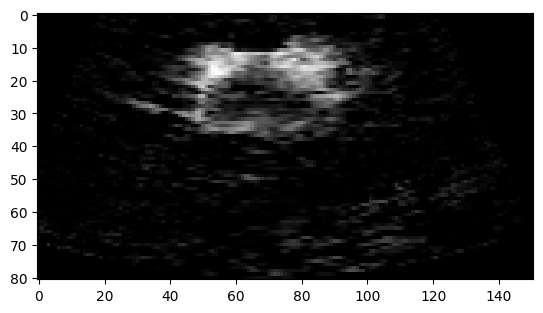

In [14]:
import matplotlib.pyplot as plt

plt.imshow(scan[70, :, :, 20], cmap='gray')

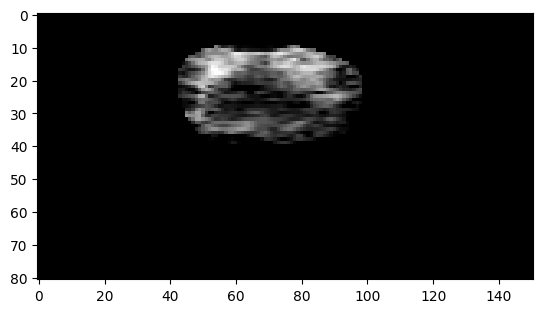

In [15]:
plt.imshow(seg[70, :, :, 20], cmap='gray')

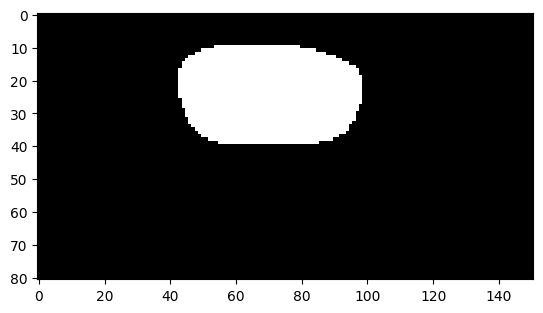

In [16]:
bolus_seg = (np.max(seg, axis=3) > 0).astype(np.uint8)
bolus_seg = binary_fill_holes(bolus_seg).astype(np.uint8)

plt.imshow(bolus_seg[70, :, :], cmap='gray')

In [17]:
import gc
import logging
import SimpleITK as sitk
import nibabel as nib
from scipy.ndimage import binary_fill_holes
from tqdm import tqdm

logger = logging.getLogger("radiomics.glcm")
logger.setLevel(logging.ERROR)

bolus_features_by_mouse = []
molecular_features_by_mouse = []
scan_names_by_mouse = []

for mouse in mouse_names:
    print("Mouse:", mouse)
    bolus_features = []; scan_names = []
    mouse_bolus_path = bolus_path / mouse
    n_scans = 0
    for bolus_file in mouse_bolus_path.iterdir():
        if n_scans == 2:
            break
        if bolus_file.name.endswith('Full4D.nii'):
            n_scans += 1
            print("Processing file:", bolus_file.name)
            scan_names.append(bolus_file.name)
            bolus_seg_file = bolus_file.parent / (bolus_file.name[:-4] + "Masked.nii")

            scan_features = []

            assert bolus_file.exists(), f"Bolus scan file {bolus_file} does not exist."
            assert bolus_seg_file.exists(), f"Bolus segmentation file {bolus_seg_file} does not exist."
            bolus_image = np.asarray(nib.load(str(bolus_file)).dataobj, dtype=np.uint8).T
            bolus_seg = np.asarray(nib.load(str(bolus_seg_file)).dataobj, dtype=np.uint8).T
            bolus_seg = (np.max(bolus_seg, axis=3) > 0).astype(np.uint8)
            bolus_seg = binary_fill_holes(bolus_seg).astype(np.uint8)
            assert bolus_image.shape[:3] == bolus_seg.shape, f"Bolus image and segmentation shapes do not match: {bolus_image.shape} vs {bolus_seg.shape}"
            bolus_seg = sitk.GetImageFromArray(bolus_seg)

            for v in tqdm(range(bolus_image.shape[3])):
                cur_scan = sitk.GetImageFromArray(bolus_image[:, :, :, v])
                try:
                    scan_features.append(
                        extractor.execute(cur_scan, bolus_seg)
                    )
                except IndexError:
                    scan_features.append({})
            bolus_features.append(scan_features)
            del bolus_image, bolus_seg, cur_scan, scan_features
            gc.collect()

    bolus_features_by_mouse.append(bolus_features)
    scan_names_by_mouse.append(scan_names)

    del bolus_features


Mouse: m904
Processing file: m904d20150410BolusFull4D.nii


  2%|▏         | 3/174 [00:01<01:03,  2.67it/s]/Users/davidspector/miniconda3/envs/QuantUS-env/lib/python3.11/site-packages/radiomics/imageoperations.py:125: RuntimeWarning: overflow encountered in scalar add
  highBound = maximum + 2 * binWidth
100%|██████████| 174/174 [00:56<00:00,  3.09it/s]


Processing file: m904d20150411BolusFull4D.nii


 68%|██████▊   | 118/174 [01:02<00:29,  1.90it/s]


KeyboardInterrupt: 